# First version of nucleusj in python

TODO:
- open data and metadata (with bioformat? OMERO?)
- visualise it
- auto-crop: 
    - Ostu threshold 
    - Connected component (MorpholibJ)
    - Component of volume > 1um are conserved
    - A bounding box around each connected component --> plus a 20 voxel surrounding
    - Group bounding boxes if they have a IoU > 0.5
    - Generate a Z-projection with the bouding boxes
    - A tabulated file with the list of each nucleus + bboxes coord in a .txt file
- segmentation:
    - do a thresholding Otsu then the modified Ostu?
    - gift-wrapping 
- surface area computation:
    - discrete geometry technique
    - NAMM: can we use ML to find the right transformation from the sphere images?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io
import tifffile as tif
# import SimpleITK as sitk
import pandas
import os
import tqdm
from PIL import Image, TiffTags, ImageSequence

from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops

import xml.etree.ElementTree as ET

In [3]:
# paths
img_path = '../data/wide_field.tif'
out_path = '../data/output/'

In [4]:
# open a single image
img = io.imread(img_path)

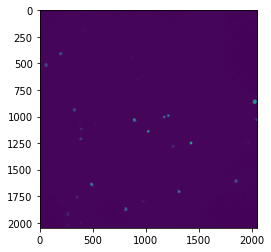

In [5]:
half = len(img)//2
plt.imshow(img[half])

## auto-crop
- Ostu threshold 
- Connected component (MorpholibJ)
- Component of volume > 1um are conserved
- A bounding box around each connected component --> plus a 20 voxel surrounding
- Group bounding boxes if they have a IoU > 0.5
- Generate a Z-projection with the bouding boxes and the nucleus numbers
- A tabulated file with the list of each nucleus + bboxes coord in a .txt file

In [6]:
# ostu threshold
thresh = threshold_otsu(img)
binary = img > thresh

# print("ostu threshold: {}".format(thresh))
# plt.imshow(binary[half])

In [7]:
# connected components
connec = label(binary)
nb_connec = len(np.unique(connec))
print("number of connected components: {}".format(nb_connec))

# plt.imshow(connec[half])

number of connected components: 105


In [8]:
# volume of a connected component
def connec_volume(connec, idx):
    """
    returns the volume in pixel of the connected component of index 'idx' form the image called 'connec'
    """
    return np.sum(connec == idx)

# print the volume of all the connected components in pixel
def connec_volume_all(connec):
    nb_connec = len(np.unique(connec))
    l_connec = []
    for idx, elm in enumerate(np.unique(connec)[1:]): # remove the bg
        l_connec += [connec_volume(connec, elm)]
    return l_connec
l_connec = connec_volume_all(connec)
print(l_connec) # list of all connected component volumes (except of the bg)

[8565, 6242, 8778, 8390, 8166, 21, 5692, 6492, 6646, 7256, 6631, 6167, 24884, 1, 8362, 5479, 7736, 1, 6664, 1, 13, 1, 6049, 5797, 8291, 14, 20, 6727, 6959, 1, 1, 1, 1, 4740, 4291, 1, 6906, 1, 6203, 4243, 1, 2999, 1, 36, 3482, 1, 4, 1, 113, 4366, 2, 1, 3738, 3360, 18351, 6, 1, 1, 1, 2, 2, 1, 1, 1, 4156, 1, 3566, 4408, 1, 1, 2, 1, 1, 1, 2976, 12683, 5696, 1, 1, 57, 1, 1, 1, 2, 4261, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1]


In [9]:
# remove connected component that are too small
# criteria (arbitrari): below 1000 pixel are removed

connec_clean = np.zeros_like(connec)
for idx, elm in enumerate(l_connec):
    if elm > 1000:
        connec_clean += (connec==(idx+1)).astype(int)*(idx+1)

# l_connec_clean = connec_volume_all(connec_clean)
# print(l_connec_clean)

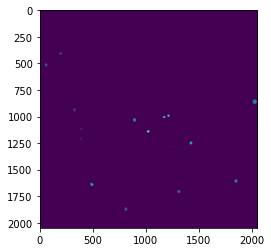

In [10]:
plt.imshow(connec_clean[half])

In [11]:
# crop each connected components by a frame of 20 pixel and save them as tif files
props = regionprops(connec_clean) 

def crop_bbox(img, bbox, margin=20):
    """
    bbox: (ax,ay,az,bx,by,bz)
    """
    # adds margin and assert it is in the right range
    bbox_a = np.array(bbox)[:3]-margin
    bbox_b = np.array(bbox)[3:]+margin
    bbox_ = np.append(bbox_a, bbox_b)
    im_shape = img.shape

    for i in range(2):
        for j in range(3):
            if bbox_[i*3+j] >= img.shape[j]:
                bbox_[i*3+j] = img.shape[j] - 1
            elif bbox_[i*3+j] < 0:
                bbox_[i*3+j] = 0
    ax,ay,az,bx,by,bz = np.array(bbox_)
    return img[ax:bx,ay:by,az:bz], np.array(bbox_)

In [17]:
img_bits = int(2**(2**np.ceil(np.log2(np.ceil(np.log2(np.max(img))))))) # log2 of the max pixel


for i in range(len(props)):
    connec_crop, bbox = crop_bbox(connec_clean, props[i].bbox)
    connec_crop = ((connec_crop / np.max(connec_crop)) * (img_bits-1)).astype(np.uint16)

    fname = out_path + str(i) + '.tif'

    io.imsave(fname, connec_crop)
    # TODO: add the metadata

In [18]:
# group bounding boxes if they have a IoU > 0.5

In [ ]:
# z projection